In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import pickle
import os

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

GeForce GTX 1080 Ti


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
DATA_VERSION = 'v8'
MODEL_VERSION = 'v8'

DATA_ROOT = os.path.join('data', DATA_VERSION)
MODEL_ROOT = os.path.join('model', MODEL_VERSION)

TRAIN = os.path.join(DATA_ROOT, f'train.pkl')
TEST = os.path.join(DATA_ROOT, f'test.pkl')
WORD_IX = os.path.join(DATA_ROOT, f'word_ix.pkl')
IX_WORD = os.path.join(DATA_ROOT, f'ix_word.pkl')

In [5]:
train = pickle.load(open(TRAIN, 'rb'))
test = pickle.load(open(TEST, 'rb'))
word_ix = pickle.load(open(WORD_IX, 'rb'))
ix_word = pickle.load(open(IX_WORD, 'rb'))
encoded_headlines = train + test

In [6]:
print('length of train: ', len(train))
print('length of test: ', len(test))

length of train:  8500
length of test:  1500


In [7]:
# General structure learned from PyTorch documentation
class myLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, vocab_size, embedding_size):
        super(myLSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        
        #self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size
        
        self.lstm = nn.LSTM(embedding_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, words):    
        
        h = torch.zeros(1, 1, self.hidden_size, requires_grad=False).to(device)
        c = torch.zeros(1, 1, self.hidden_size, requires_grad=False).to(device)
        
        # embed words
        w_embedding = self.embedding(words)
        w_embedding = w_embedding.view(len(words), 1, self.embedding_size)

        # run the lstm layer
        output, (h, c) = self.lstm(w_embedding, (h, c))
        result = self.linear(output)
        
        return result

In [8]:
# in_size = max_len-1 # should be size of the inputting sentence/batch (how many words are being inputted)
h_size = 128 # should be size of learned parameters
out_size = len(word_ix) # should be size of vocab
vocab_size = len(word_ix) # total unique words in corpus
embed_size = 64 # dimension of each word's embedding

learning_rate = 0.001
num_epochs = 50


model = myLSTM(h_size, out_size, vocab_size, embed_size)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

losses = []

for i in range(num_epochs):
    total_loss = 0
     
    for s in train:
        
        optimizer.zero_grad()
        
        # predict until the word right before the last word
        predictions = model(torch.tensor(s, requires_grad=False)[:-1].to(device))    
        
        # loss = sent_loss(predictions, s).cpu()
        # print(predictions)
        loss = criterion(predictions.squeeze(), torch.tensor(s, requires_grad=False)[1:].to(device)).cpu()
        total_loss += loss.detach().numpy()

        loss.backward()
        optimizer.step()
        
    avg_total_loss = total_loss / len(train)
    losses.append(avg_total_loss)
    diff = losses[i]-losses[i-1] if i > 0 else 0
    print('epoch: ', i, 'loss: ', avg_total_loss, 'difference: ', diff)

epoch:  0 loss:  7.613543294570025 difference:  0
epoch:  1 loss:  6.539339377024595 difference:  -1.0742039175454305
epoch:  2 loss:  5.847812506072661 difference:  -0.6915268709519333
epoch:  3 loss:  5.251382148399072 difference:  -0.5964303576735892
epoch:  4 loss:  4.734093979484895 difference:  -0.5172881689141775
epoch:  5 loss:  4.300923742588829 difference:  -0.43317023689606593
epoch:  6 loss:  3.937722816895036 difference:  -0.3632009256937927
epoch:  7 loss:  3.6383383909113265 difference:  -0.2993844259837095
epoch:  8 loss:  3.389252810541321 difference:  -0.2490855803700054
epoch:  9 loss:  3.167664522570722 difference:  -0.22158828797059904
epoch:  10 loss:  2.985923453898991 difference:  -0.18174106867173112
epoch:  11 loss:  2.835120372891426 difference:  -0.1508030810075649
epoch:  12 loss:  2.690658264636993 difference:  -0.14446210825443284
epoch:  13 loss:  2.590896346085212 difference:  -0.09976191855178129
epoch:  14 loss:  2.49216466310445 difference:  -0.09873

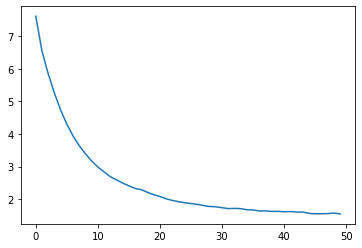

In [9]:
plt.plot(losses)

In [10]:
# saving models and trained parameters
def saveModel(model, name, root, description):
    model = model.cpu()
    
    if os.path.exists(root) == False:
        os.makedirs(root)
    
    desc = open(os.path.join(root, 'description.txt'), 'w')
    desc.write(description + '\n')
    desc.close()
    
    pickle.dump(model, open(name, 'wb'))

In [11]:
def convertToWord(s, ixw, wix):
    res = ''
    for w in s:
        print(w)
        res += ixw[w] + ' '
    return res

In [12]:
def testModel(model, testSet, device, encoded_headlines):
    model.eval()
    
    with torch.no_grad():
        total_loss = 0
        for s in testSet:
            
            # predict until the word right before the last word
            predictions = model(torch.tensor(s[:-1], requires_grad=False).to(device))
            #pred = [np.argmax(predictions[i].cpu().detach().numpy()) for i in range(len(predictions))]
            #print('predicted: ', pred, 'truth: ', s)
            
            loss = criterion(predictions.squeeze(), torch.tensor(s)[1:].to(device)).cpu()   
            total_loss += loss.detach().numpy()
            #print('loss: ', loss, 's: ', s)
            
        print('total_loss: ', total_loss)
        print('len(testSet): ', len(testSet))
        avg_total_loss = total_loss / len(testSet)

        print('avg. loss on test set: ', avg_total_loss)
    
    model.train()

In [56]:
def predictSent(modelName, sentence, wordIndex):
    # model = torch.load(modelName)
    model = pickle.load(open(modelName, 'rb'))
    model = model.to(device)
    model.eval()
    max_len = 5
    sent_words = sentence.split()
    encoded_sent = [word_ix['<START>']] + [word_ix[w] for w in sentence.split()]
    
    ix_word = defaultdict(str)
    for w in wordIndex:
        ix_word[wordIndex[w]] = w
    
    # predict until we reach the END signal
    while True:
        with torch.no_grad():
            preds = model(torch.tensor(encoded_sent, requires_grad=False).to(device))
        softmax = nn.Softmax(dim=1)
        preds = softmax(preds.squeeze())
        #print(torch.sum(preds[-1]))
        pred_word = preds[-1].cpu().detach().numpy().tolist()
        
        pred_word = list(zip(pred_word, range(len(pred_word))))
        pred_word.sort(reverse=True)
        
        
        # randomly from the top k words to be the next word
        k = 3
        next_word = random.choice(pred_word[:k])
        while len(encoded_sent) < max_len and next_word[1] == word_ix['<END>']:
            next_word = random.choice(pred_word[:k])

        #print(next_word)
        encoded_sent.append(next_word[1])
        
        if len(encoded_sent) >= max_len and next_word[1] == word_ix['<END>']:
            break
        
    # decode the sentence afterward
    pred_sentence = [ix_word[i] for i in encoded_sent]
    
    model.train()
    return pred_sentence

In [14]:
model_name = os.path.join(MODEL_ROOT, f'model.pkl')
model_desc = f'{num_epochs} epochs, {len(train)} training size, {h_size} hidden size, {embed_size} embedding size, dropout=0.3'
saveModel(model, model_name, MODEL_ROOT, model_desc)

In [15]:
# model = torch.load('model_v4-50_epochs-8k-512h.pt')
model = pickle.load(open(model_name, 'rb'))
model = model.to(device)

In [16]:
testModel(model, test, device, encoded_headlines)

total_loss:  20860.629021286964
len(testSet):  1500
avg. loss on test set:  13.907086014191309


In [60]:
for i in range(10):
    sent = 'car'
    pred = predictSent(model_name, sent, word_ix)
    print(' '.join(pred))

<START> car war push on the market for australia begins defends problem <END>
<START> car manufacturing dairy reporter a refugee people webber dies in inverell <END>
<START> car manufacturing job losses to smr a open <END>
<START> car crushes pedestrian to oil injured from schools <END>
<START> car crushes pedestrian at hunter baby fishing found on migrant coast <END>
<START> car war a education south east west voices concern <END>
<START> car crushes about traditional world war to childrens australia <END>
<START> car war urged in old delays heading <END>
<START> car crushes about fire into fatal funding from state ashley <END>
<START> car war urged to ahead with farming for nrl closer repairs <END>
